In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

Task 1 of Project 3.  Fully Connected Neural Network.

In [2]:
def run_task_1(training_images, testing_images, labels):
    #Construct network model
    task1_model = Sequential()
    task1_model.add(layers.Dense(units=1024,input_shape=(1024,), activation='tanh'))
    task1_model.add(layers.Dense(units=512, activation='sigmoid'))
    task1_model.add(layers.Dense(units=100, activation='relu'))
    task1_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_labels = enc.fit_transform(labels)
     
    #Create and fit the scaler to the data
    scaler = MinMaxScaler()
    scaled_training_images=scaler.fit_transform(training_images)
    scaled_testing_images=scaler.transform(testing_images)
    task1_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task1_model.fit(x=scaled_training_images,y=encoded_labels, epochs=15, validation_split=0.2)
    cm = task1_model.predict(x=scaled_testing_images)
    print(len(cm))
    sn.heatmap(cm, annot=False)
    
    return task1_model

In [4]:
#read in training and testing csv with labels for our data
training_df = pd.read_csv('fairface_label_train.csv', nrows=1000)
training_df=training_df.drop('file',axis=1) 
training_df=training_df.drop('service_test',axis=1)
training_df=training_df.drop('age',axis=1)

#training_df=training_df.drop('race',axis=1)
training_df=training_df.drop('gender', axis=1)

print(training_df.head())

testing_df = pd.read_csv('fairface_label_val.csv', nrows=1000)

#read in images that we will be predicting on
training_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    testing_images[i-1]=im

         race
0  East Asian
1      Indian
2       Black
3      Indian
4      Indian


Epoch 1/15
25/25 [==============================] - 3s 61ms/step - loss: 1.9397 - accuracy: 0.2025 - val_loss: 1.9338 - val_accuracy: 0.1600
Epoch 2/15
25/25 [==============================] - 1s 21ms/step - loss: 1.9332 - accuracy: 0.1925 - val_loss: 1.9283 - val_accuracy: 0.1750
Epoch 3/15
25/25 [==============================] - 1s 21ms/step - loss: 1.9223 - accuracy: 0.2188 - val_loss: 1.9187 - val_accuracy: 0.1750
Epoch 4/15
25/25 [==============================] - 1s 26ms/step - loss: 1.9212 - accuracy: 0.2013 - val_loss: 1.9292 - val_accuracy: 0.1800
Epoch 5/15
25/25 [==============================] - 1s 23ms/step - loss: 1.9162 - accuracy: 0.2037 - val_loss: 1.9493 - val_accuracy: 0.1750
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 1.9111 - accuracy: 0.2113 - val_loss: 1.9147 - val_accuracy: 0.1750
Epoch 7/15
25/25 [==============================] - 0s 9ms/step - loss: 1.9055 - accuracy: 0.2200 - val_loss: 1.9292 - val_accuracy: 0.1800
Epoch 8/15
25/2

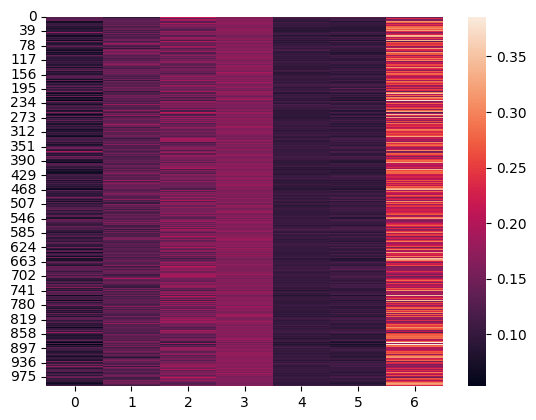

In [5]:
mod = run_task_1(training_images=training_images, testing_images=testing_images, labels=training_df)

Task 2 of Project 3.   Small Convolutional Neural Network.

In [77]:
def run_task_2(training_images, testing_images, labels):
    #build the network
    task2_model = Sequential()
    task2_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task2_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task2_model.add(layers.Flatten())
    task2_model.add(layers.Dense(units=100, activation='relu'))
    task2_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_labels = enc.fit_transform(labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    print(training_images[0].shape)
    task2_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task2_model.fit(x=training_images,y=encoded_labels, epochs=15, validation_split=0.2)
    cm = task2_model.predict(x=testing_images)
    print(len(cm))
    sn.heatmap(cm, annot=False)
    

(32, 32)
Epoch 1/15
25/25 [==============================] - 1s 31ms/step - loss: 1.9311 - accuracy: 0.1950 - val_loss: 1.9312 - val_accuracy: 0.1750
Epoch 2/15
25/25 [==============================] - 0s 14ms/step - loss: 1.9136 - accuracy: 0.2037 - val_loss: 1.9296 - val_accuracy: 0.1650
Epoch 3/15
25/25 [==============================] - 0s 12ms/step - loss: 1.9057 - accuracy: 0.1975 - val_loss: 1.9171 - val_accuracy: 0.1750
Epoch 4/15
25/25 [==============================] - 0s 13ms/step - loss: 1.8967 - accuracy: 0.2100 - val_loss: 1.9210 - val_accuracy: 0.1800
Epoch 5/15
25/25 [==============================] - 0s 13ms/step - loss: 1.8875 - accuracy: 0.1988 - val_loss: 1.9118 - val_accuracy: 0.1850
Epoch 6/15
25/25 [==============================] - 0s 14ms/step - loss: 1.8766 - accuracy: 0.2050 - val_loss: 1.9008 - val_accuracy: 0.1950
Epoch 7/15
25/25 [==============================] - 0s 13ms/step - loss: 1.8678 - accuracy: 0.2450 - val_loss: 1.8922 - val_accuracy: 0.2000
Epoc

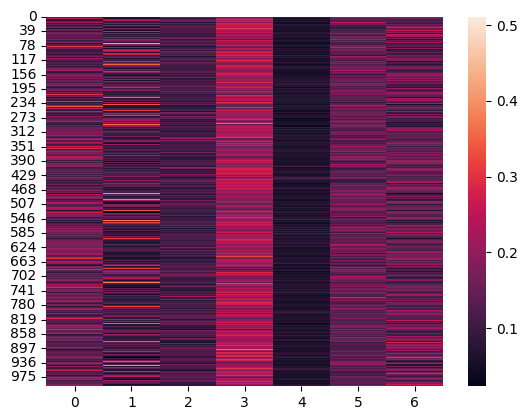

In [79]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)

#training_labels=training_labels.drop('race',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_2 = run_task_2(training_images=training_images, testing_images=testing_images, labels=training_labels)

Task 3 of Project 3.  Create our own convolutional layer.

In [75]:
def run_task_3(training_images, testing_images, labels):
    #build the network
    task3_model = Sequential()
    task3_model.add(layers.Conv2D(filters=40, kernel_size=(2,2), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task3_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task3_model.add(layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', 
                                  strides=1, padding='valid'))
    task3_model.add(layers.MaxPooling2D(pool_size=(3,3)))
    task3_model.add(layers.Conv2D(filters=20, kernel_size=(4,4), activation='relu', 
                                  strides=1, padding='valid'))
    task3_model.add(layers.Flatten())
    task3_model.add(layers.Dense(units=100, activation='relu'))
    task3_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_labels = enc.fit_transform(labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    task3_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task3_model.fit(x=training_images,y=encoded_labels, epochs=15, validation_split=0.2)
    cm = task3_model.predict(x=testing_images)
    print(len(cm))
    sn.heatmap(cm, annot=False)

Epoch 1/15
25/25 [==============================] - 1s 27ms/step - loss: 1.9433 - accuracy: 0.1338 - val_loss: 1.9440 - val_accuracy: 0.1700
Epoch 2/15
25/25 [==============================] - 0s 17ms/step - loss: 1.9387 - accuracy: 0.1775 - val_loss: 1.9415 - val_accuracy: 0.1650
Epoch 3/15
25/25 [==============================] - 0s 19ms/step - loss: 1.9353 - accuracy: 0.1912 - val_loss: 1.9397 - val_accuracy: 0.1700
Epoch 4/15
25/25 [==============================] - 0s 17ms/step - loss: 1.9324 - accuracy: 0.2050 - val_loss: 1.9381 - val_accuracy: 0.1750
Epoch 5/15
25/25 [==============================] - 0s 16ms/step - loss: 1.9299 - accuracy: 0.2000 - val_loss: 1.9368 - val_accuracy: 0.1750
Epoch 6/15
25/25 [==============================] - 0s 17ms/step - loss: 1.9276 - accuracy: 0.2037 - val_loss: 1.9358 - val_accuracy: 0.1750
Epoch 7/15
25/25 [==============================] - 0s 19ms/step - loss: 1.9258 - accuracy: 0.2037 - val_loss: 1.9351 - val_accuracy: 0.1750
Epoch 8/15
25

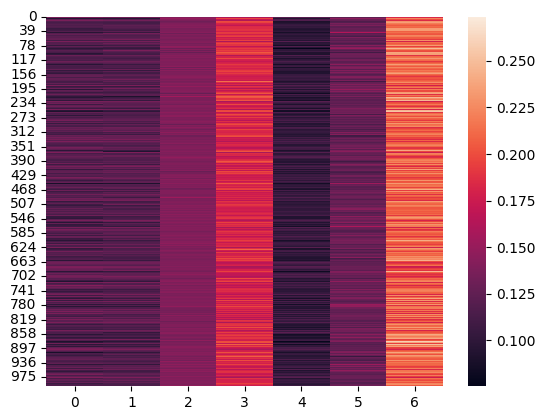

In [76]:
#read in training labels
training_labels=pd.read_csv('fairface_label_train.csv', nrows=1000)
training_labels=training_labels.drop('file',axis=1) 
training_labels=training_labels.drop('service_test',axis=1)
training_labels=training_labels.drop('age',axis=1)

#training_labels=training_labels.drop('race',axis=1)
training_labels=training_labels.drop('gender', axis=1)
#read in images
training_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,32,32))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    testing_images[i-1]=im

mod_3 = run_task_3(training_images=training_images, testing_images=testing_images, labels=training_labels)

Task 4 of Project 3.  Create Your Own Convolutional Neural Network On Both Tasks Simultaneously.

In [ ]:
def run_task_4(training_images, testing_images, labels):
    #build the network
    task4_model = Sequential()
    task4_model.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', 
                                  strides=1, padding='valid', input_shape=(32,32,1)))
    task4_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    task4_model.add(layers.Flatten())
    task4_model.add(layers.Dense(units=100, activation='relu'))
    task4_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_labels = enc.fit_transform(labels)
    
    #scale the training and testing data sets using a model fit to the training set
    min_max_scalar = MinMaxScaler()
    for i in range(0, len(training_images)):
        training_images[i] = min_max_scalar.fit_transform(training_images[i])
    for i in range(0, len(testing_images)):
        testing_images[i] = min_max_scalar.transform(testing_images[i])
        
    print(training_images[0].shape)
    task4_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task4_model.fit(x=training_images,y=encoded_labels, epochs=15, validation_split=0.2)
    cm = task4_model.predict(x=testing_images)
    print(len(cm))
    sn.heatmap(cm, annot=False)